# y-y' distribution

In [1]:
import sys
import os
from os.path import join
from pprint import pprint
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy import ndimage
import proplot as pplt
from datetime import datetime

sys.path.append('..')
from tools import image_processing as ip
from tools import utils
from tools import plotting as mplt
from tools import energyVS06 as energy

# sys.path.append('/Users/46h/Research/code/btf-scripts/')
sys.path.append('..')
import scan_patterns as sp

ModuleNotFoundError: No module named 'scan_patterns'

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['cmap.discrete'] = False

## Load data 

In [3]:
datadir = '/Diagnostics/Data/Measurements/2022-07-01/'
filenames = os.listdir(datadir)
filenames

['220701110434-x-emittance2d.h5',
 '220701111357-x-emittance2d.h5',
 '220701125856-x-emittance2d.h5',
 '220701110339-x-emittance2d.h5',
 '220701134227-y-emittance2d.h5',
 '220701141815-y-emittance2d.h5',
 '220701151627-y-emittance2d.h5',
 '220701150551-y-emittance2d.h5',
 '220701191040-y-emittance2d.h5',
 '220701143627-y-emittance2d.h5',
 '220701191915-x-emittance2d.h5',
 '220701223752-x-emittance2d.h5',
 '220701224753-y-emittance2d.h5',
 '220701193135-x-emittance2d.h5',
 '220701221102-x-emittance2d.h5',
 '220701225535-y-emittance2d.h5']

In [8]:
filename = '220701143627-y-emittance2d.h5'
file = h5py.File(join(datadir, filename), 'r')
data = file['scandata']
pprint(data.dtype.fields)

mappingproxy({'bcm04': (dtype('<f8'), 16),
              'cam06_Integral': (dtype('<f8'), 32),
              'cam06_Saturation': (dtype('<f8'), 24),
              'iteration': (dtype('int64'), 8),
              'timestamp': (dtype('<f8'), 0),
              'y_PositionSync': (dtype('<f8'), 48),
              'yp_PositionSync': (dtype('<f8'), 40)})


In [9]:
acts = ['yp_PositionSync', 'y_PositionSync']
cam = None
for name in data.dtype.names:
    if name.lower().startswith('cam'):
        cam = name.split('_')[0]
        break
if cam is not None:
    for name in data.dtype.names:
        if name.lower().startswith(cam) and not name.startswith(cam):
            cam = cam[0].upper() + cam[1:]
            break
    print('cam =', cam)
    sdiag = [f'{cam}_Integral', f'{cam}_Saturation', 'bcm04']
    for i in range(len(sdiag)):
        if sdiag[i] not in data.dtype.names and sdiag[i].lower() in data.dtype.names:
            sdiag[i] = sdiag[i].lower()

    signal = data[sdiag[0]][:]
else:
    sdiag = ['SlowQ', 'fc12', 'bcm04']
    signal = np.abs(data[sdiag[0]])

cam = cam06


In [10]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

environment
--------------
timestamp: [1.65670059e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'emit2d/y-emittance2d.py']
work_dir: [b'/home/46h/btf-scripts']

metadata
--------------
timestamp: [1.6567006e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [5.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.1]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.3]
BTF_MEBT_Mag:PS_DCH01:I_Set: [4.7]
BTF_MEBT_Mag:PS_DCV01:I_Set: [-3.]
BTF_MEBT_Mag:PS_DCH02:I_Set: [5.]
BTF_MEBT_Mag:PS_DCV02:I_Set: [-2.]
BTF_MEBT_Mag:PS_DCH34:

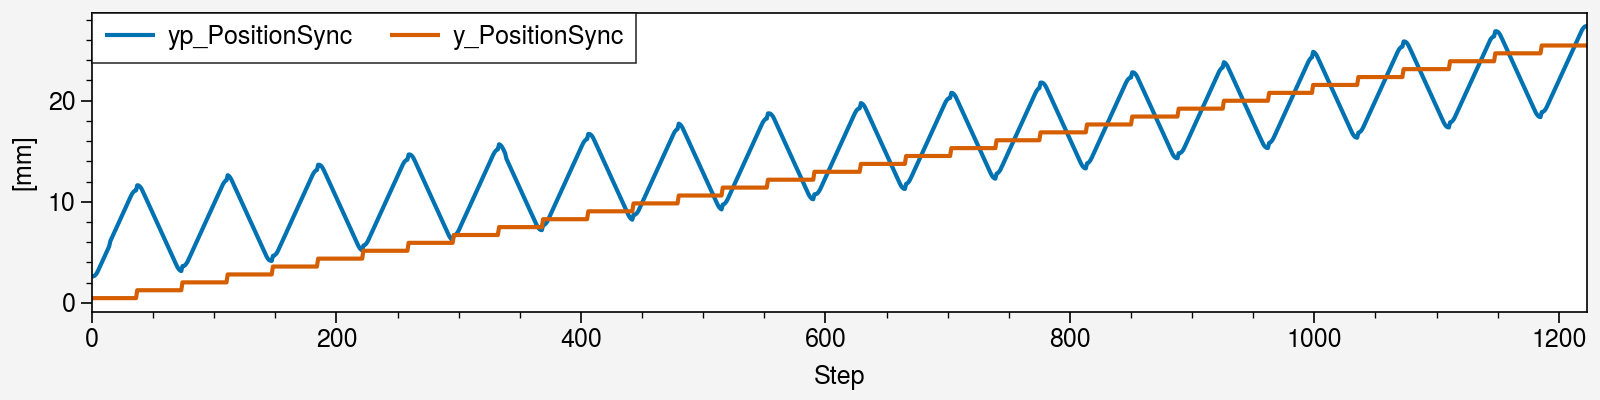

In [11]:
fig, ax = pplt.subplots(figsize=(8, 2))
for act in acts:
    ax.plot(data[:, act], marker=None, label=act)
ax.legend()
ax.format(xlabel='Step', ylabel='[mm]')

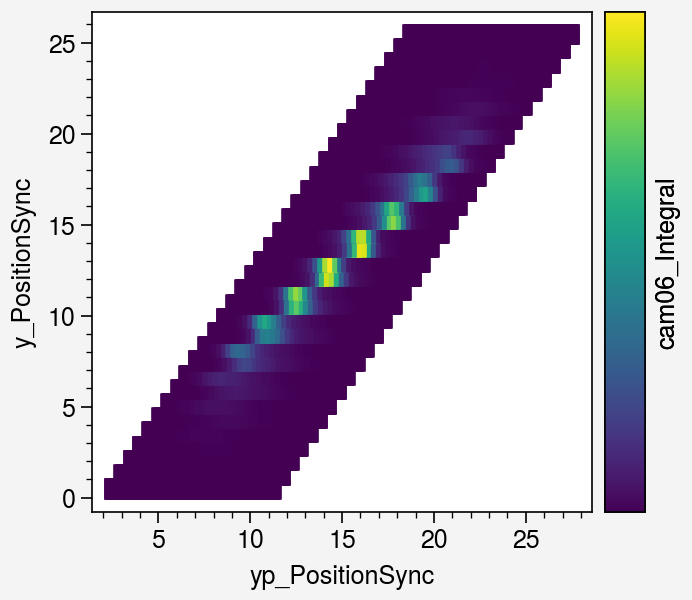

In [12]:
fig, ax = pplt.subplots()
ax.scatter(data[:, acts[0]], data[:, acts[1]], marker='s', s=50, 
           c=signal, norm='log', 
           colorbar=True, colorbar_kw=dict(label=sdiag[0]))
ax.format(xlabel=acts[0], ylabel=acts[1])

Diagnostic: cam06_Integral
Max = 0.657
Min = 0.107
Mean = 0.122


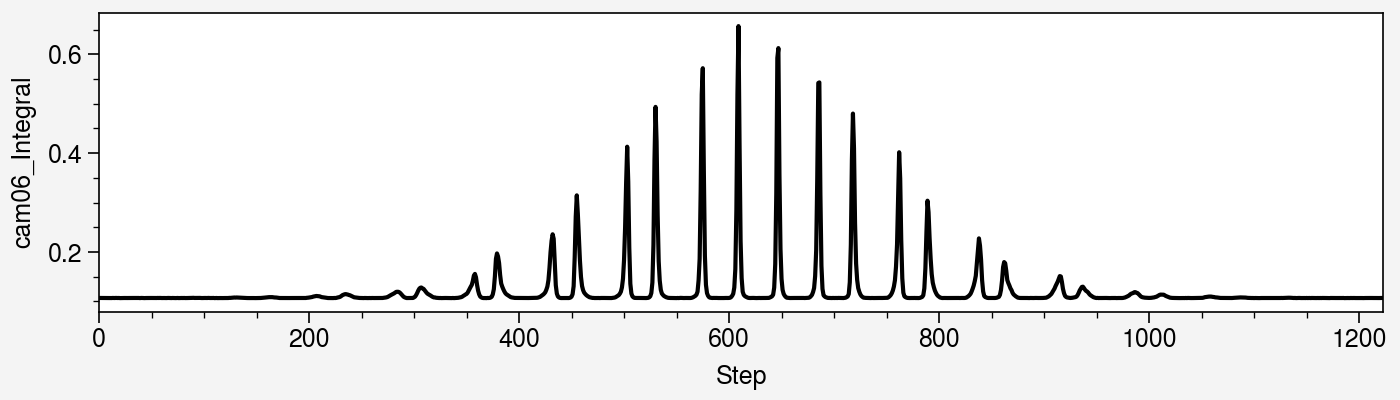

Diagnostic: cam06_Saturation
Max = 0.997
Min = 0.001
Mean = 0.024


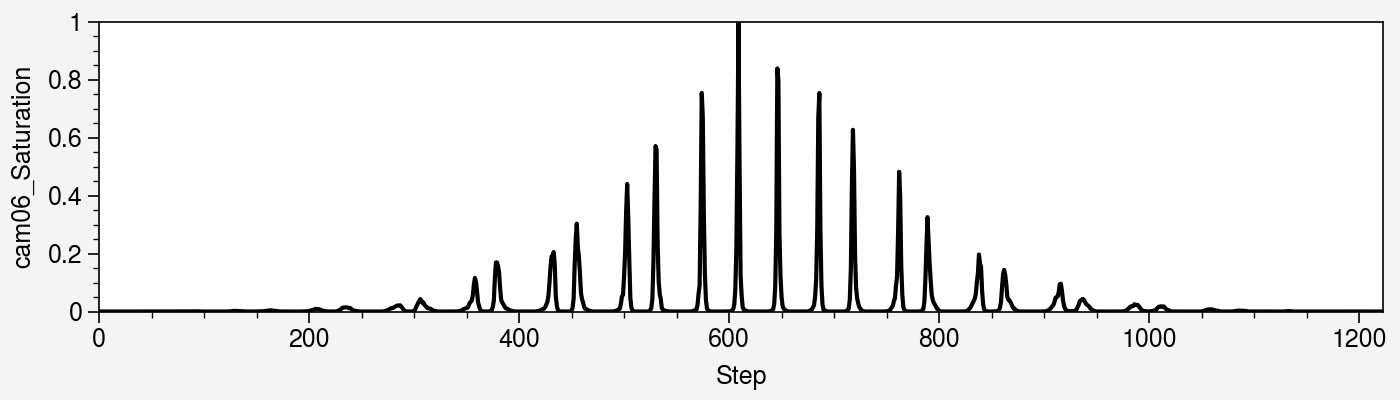

Diagnostic: bcm04
Max = -29.063
Min = -29.415
Mean = -29.243


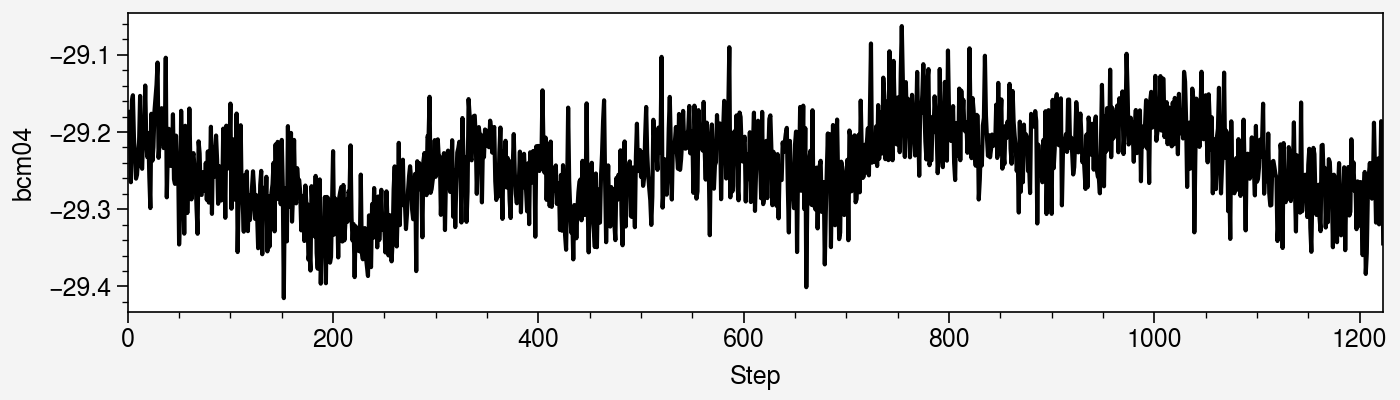

In [13]:
for item in sdiag:
    print(f'Diagnostic: {item}')
    print('Max = {:.3f}'.format(np.max(data[:, item])))
    print('Min = {:.3f}'.format(np.min(data[:, item])))
    print('Mean = {:.3f}'.format(np.mean(data[:, item])))
    fig, ax = pplt.subplots(figsize=(7.0, 2.0))
    ax.plot(data[:, item], color='black', marker='.', ms=0, label=item)
    if 'saturation' in item.lower():
        ax.set_ylim(0, 1)
    ax.format(xlabel='Step', ylabel=item)
    plt.show()

In [14]:
print('Average beam current:', np.mean(data['bcm04']))

Average beam current: -29.242936449046805


#### Pick frames for background calculation

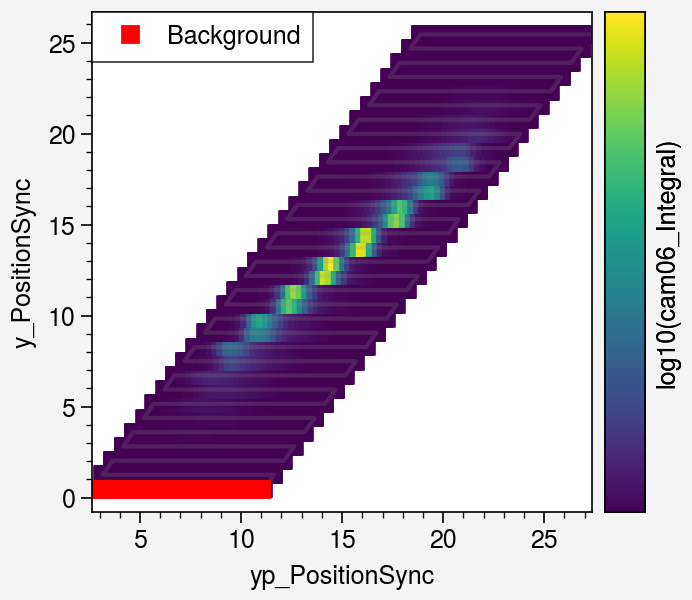

In [15]:
signame = sdiag[0]
bgidx = np.arange(1, 35)

fig, ax = pplt.subplots()
ax.plot(data[:, acts[0]], data[:, acts[1]], alpha=0.2, color='grey')
ax.scatter(data[:, acts[0]], data[:, acts[1]], marker='s', 
           c=signal, norm='log',
           colorbar=True, colorbar_kw=dict(label=f'log10({signame})'))

ax.plot(data[bgidx, acts[0]], data[bgidx, acts[1]], 'rs', label='Background')
ax.legend()
ax.format(xlabel=acts[0], ylabel=acts[1])

## Threshold 

In [18]:
signal = signal - np.min(signal)
signal = signal / np.max(signal)
thresh = 0.001
valid, = np.where(signal >= thresh)
print(f'signame = {signame}')
print(f'Est dynamic range 10^{np.log10(thresh / np.max(signal[valid])):.3f}')

signame = cam06_Integral
Est dynamic range 10^-3.000


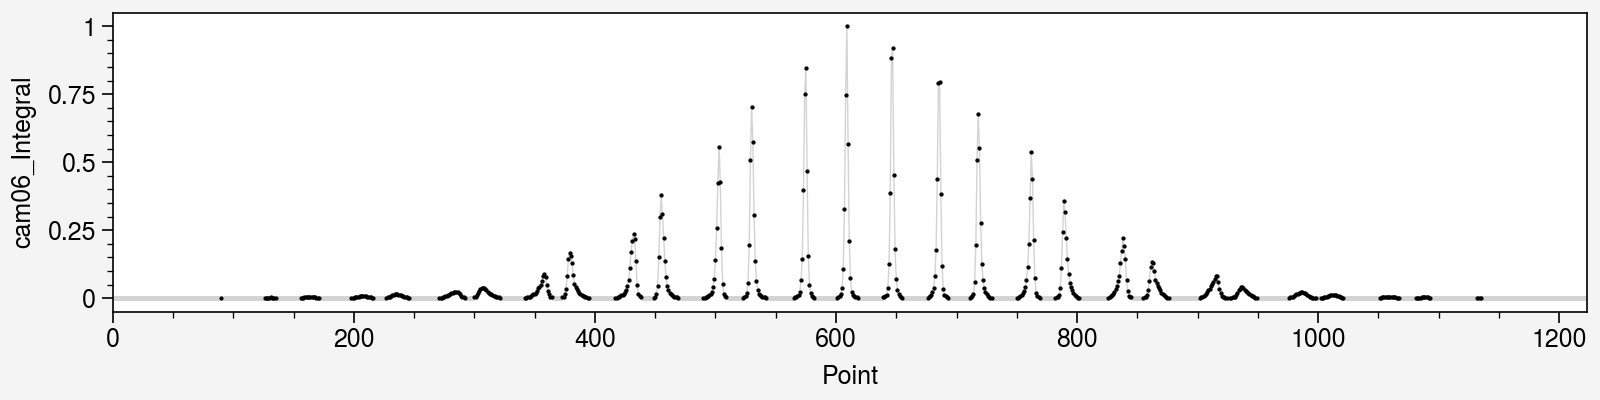

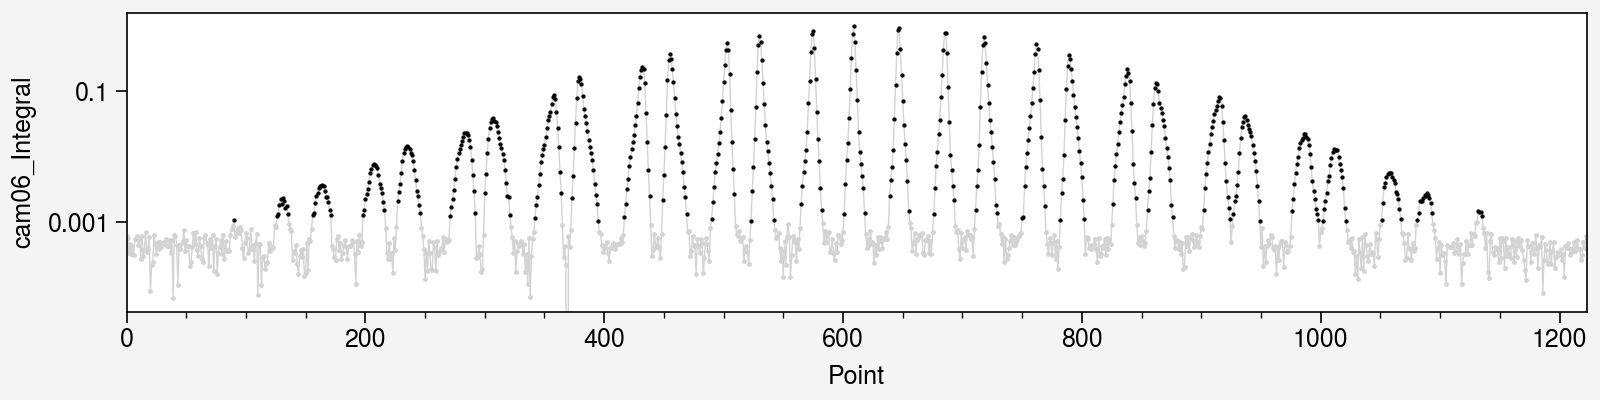

In [19]:
for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 2.0))
    ax.plot(signal, color='lightgray', marker='.', lw=0.5, ms=1.5)
    ax.plot(valid, signal[valid], marker='.', s=1, color='black', lw=0, label='Above thresh')
    ax.format(xlabel='Point', ylabel=signame, yscale=yscale)
    plt.show()

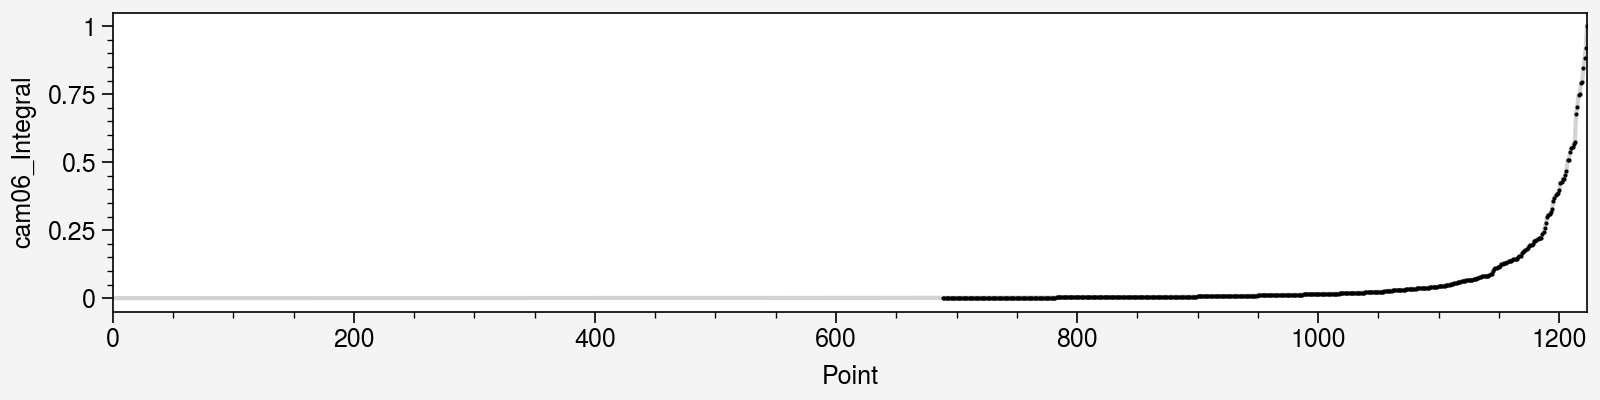

In [20]:
signal_sorted = np.sort(signal)
_idx, = np.where(signal_sorted >= thresh)

fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.plot(np.sort(signal), color='lightgray')
ax.plot(_idx, signal_sorted[_idx], marker='.', color='black', lw=0, s=1, label='Above thresh')
ax.format(xlabel='Point', ylabel=signame,)

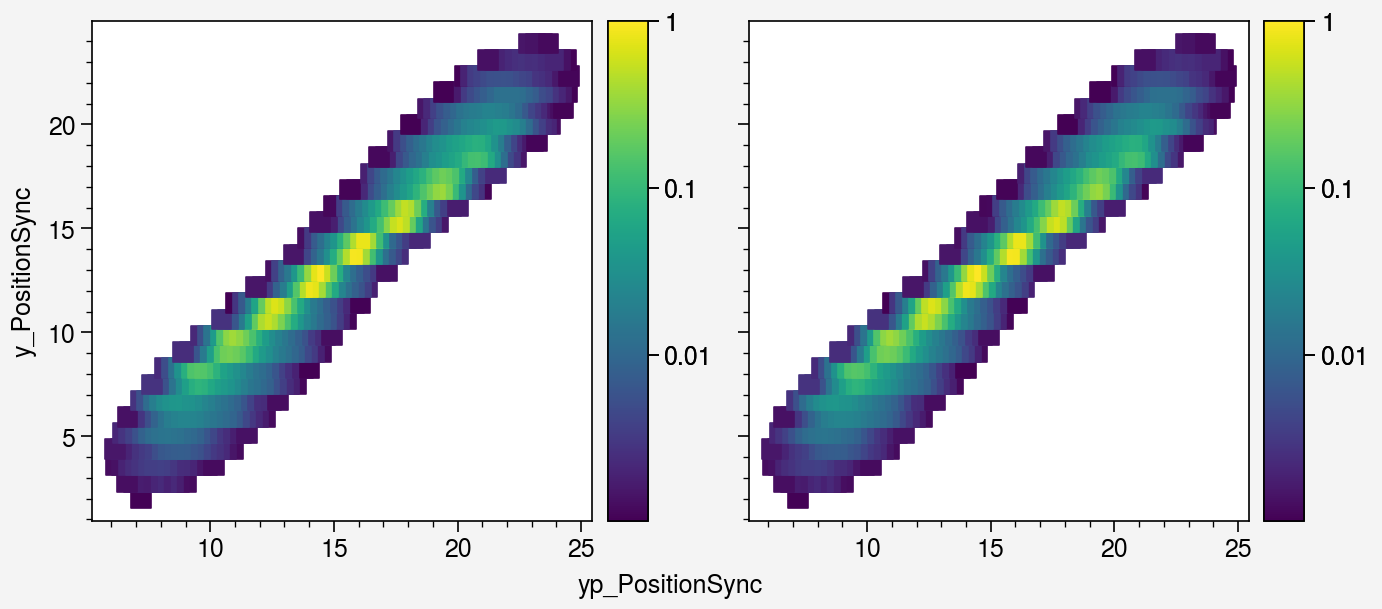

In [21]:
fig, axes = pplt.subplots(ncols=2)
for mask, ax in zip([False, True], axes):
    c = signal[valid]
    ax.scatter(
        data[valid, acts[0]], data[valid, acts[1]], marker='s', s=50,
        c=c, norm='log',
        colorbar=True
    )
axes[1].format(xlim=axes[0].get_xlim(), ylim=axes[0].get_ylim())
axes.format(xlabel=acts[0], ylabel=acts[1])

In [22]:
print(len(signal[valid]) / len(signal))

0.43709150326797386


## Measure against new scan boundaries

In [ ]:
reprate = 5.0
navg = 0
ndim = 2
variables = {
    'x2': {
        'pvname': 'ITSF_Diag:Slit_VT06',
        'center': 13.25,
        'distance': 15.0,
        'steps': 64,
        'min': +4.0,
        'max': +22.5,
    },
    'x1': {
        'pvname': 'ITSF_Diag:Slit_VT04',
        'center': 12.5,
        'distance': 15.0,
        'steps': 64,
        'min': -50.0, 
        'max': +50.0,
    },
}
keys = list(variables)
M = np.identity(ndim)
M[keys.index('x1'), keys.index('x2')] = 0.0  
M[keys.index('x2'), keys.index('x1')] = 0.65

Minv = np.linalg.inv(M)
center = np.array([variables[keys[i]]['center'] for i in range(ndim)])
distance = np.array([variables[keys[i]]['distance'] for i in range(ndim)])

In [ ]:
points = np.vstack([data[:, acts[0]], data[:, acts[1]]]).T
points_n = utils.apply(Minv, points - center)
points_nn = points_n / (0.5 * distance)

In [ ]:
fig, ax = pplt.subplots()
ax.scatter(
    points[:, 1], 
    points[:, 0], 
    marker='o', 
    ms=8,
    color='lightgray',
    alpha=0.75,
    ec='None',
)
ax.scatter(
    points[valid, 1], 
    points[valid, 0], 
    marker='o', 
    ms=8,
    color='pink6',
    ec='None',
    label='above thresh',
)
ax.legend()
ax.format(xlabel=acts[1], ylabel=acts[0])
# plt.savefig('meas_pts.png')
plt.show()

In [ ]:
# Run points generator
kws = dict(
    variables=variables, 
    M=M, 
    reprate=reprate,
    navg=navg, 
#     boundary='ellipsoid',  # {None, 'ellipsoid'} 
    R=1.11,
    exclude_outside_box=True,
)
lgen = list(sp.gen(**kws))

# Reshape
if navg > 0:
    new_points = np.zeros((len(lgen), ndim))
    for i in range(len(lgen)):
        new_points[i, :] = lgen[i][0]
else:
    lgen = np.array(lgen)
    new_points = np.zeros((2 * lgen.shape[0], ndim))
    for i in range(ndim):
        new_points[:, i] = lgen[:, i, :2].ravel()
    
# Normalize generated points.
new_points_n = utils.apply(Minv, new_points - center)
    
# Compute ellipse coordinates.
_distance = distance.copy()
if 'R' in kws:
    _distance *= kws['R']
phi = np.linspace(0.0, 2.0 * np.pi, 100)
ell_xx_n = 0.5 * _distance[0] * np.cos(phi) 
ell_yy_n = 0.5 * _distance[1] * np.sin(phi)
ell_xx, ell_yy = utils.apply(M, np.vstack([ell_xx_n, ell_yy_n]).T).T

View radial distribution in normalized coordinates.

In [ ]:
radii = np.sqrt(np.sum(np.square(points_nn), axis=1))
max_radius = np.max(radii[valid])
print(f'max radius with signal = {max_radius}')

fig, ax = pplt.subplots(figsize=(4, 2))
bins = 50
ax.hist(radii, color='lightgray', bins=bins, label='all')
ax.hist(radii[valid], color='black', bins=bins, label='above thresh')
ax.axvline(max_radius, color='pink', label='max radius')
ax.legend(loc='top', framealpha=0)
ax.format(xlabel='radius', ylabel='num. points')
plt.show()

Plot proposed scan path over measured signal.

In [ ]:
fig, axes = pplt.subplots(ncols=2, wspace=None, figwidth=None, share=False)
c = np.ma.masked_less_equal(signal, thresh) if mask else signal
for ax, _points, _new_points in zip(axes, [points, points_n], [new_points, new_points_n]):
#     ax.scatter(points[:, 0], points[:, 1], marker='s', c=signal, norm='log')
    ax.scatter(
        _points[:, 0], 
        _points[:, 1], 
        marker='o', 
        ms=8,
        color='lightgray',
        alpha=0.75,
        label='signal',
        ec='None',
    )
    ax.scatter(
        _points[valid, 0], 
        _points[valid, 1], 
        marker='o', 
        ms=8,
        color='pink4',
        ec='None',
#         label='signal',
    )
    ax.plot(_new_points[:, 0], _new_points[:, 1], marker='.', s=3, lw=1.0, color='gray', label='scan')
axes.format(xlabel=acts[0], ylabel=acts[1], toplabels=['Sheared', 'Un-sheared'])
for i, (ax, x, y) in enumerate(zip(axes, [ell_xx, ell_xx_n], [ell_yy, ell_yy_n])):
    _center = center.copy()
    if i == 1:
        _center[:] = 0.0
#     ax.plot(x + _center[0], y + _center[1], color='black', ls='-', lw=1.0, zorder=0)
axes[0].legend(ncols=1, loc='upper left')
for ax in axes:
    xmin, xmax = ax.get_xlim()
    if xmin > xmax:
        xmin, xmax = xmax, xmin
    delta = 1.0
    xmin -= delta
    xmax += delta
    ax.format(xlim=(xmin, xmax))
# plt.savefig(f'xxpp_ellipse_scan_navg{navg}.png')
lims, lims_n = [(ax.get_xlim(), ax.get_ylim()) for ax in axes]
plt.show()

## Snug scan (experimental)

Learn the coordinates of first/last signal point on each sweep; use this to define new boundaries that hug the distribution.

In [ ]:
iterations = data['iteration'].copy()
surface = utils.get_boundary_points(iterations, points, signal, thresh, pad=3.0, tol=0.2)

Save this file to feed it to scan engine (not a good long-term solution).

In [ ]:
# np.save('/Users/46h/Research/btf/btf-scripts/temp_data/x-emittance2d-surface.npy', surface)

In [ ]:
norm = False
_points = points_n if norm else points
_surface = surface_n if norm else surface
_lims = lims_n if norm else lims

In [ ]:
fig, ax = pplt.subplots()
ax.scatter(
    _points[valid, 0], _points[valid, 1], 
    marker='.', 
    ms=8,
    color='pink7',
)
for pts in _surface:
    ax.plot(pts[:, 0], pts[:, 1], color='black', lw=0, marker='|')
ax.format(xlabel='x2', ylabel='x1', xlim=_lims[0], ylim=_lims[1])
# plt.savefig(f'xxpp_ellipse_scan_navg{navg}.png')
plt.show()

In [ ]:
i, j = 1, 0

fig, ax = pplt.subplots()
ax.scatter(
    _points[:, i], _points[:, j], 
    marker='.', 
    ms=8,
    color='lightgray',
#     label='noise'
)
ax.scatter(
    _points[valid, i], _points[valid, j], 
    marker='.', 
    ms=8,
    color='pink7',
    label='signal',
)
for k in range(2):
    label = None
    if k == 0:
        label = 'interpolated boundary'
    ax.plot(surface[k][:, i], surface[k][:, j], color='black', lw=1.0, label=label)
ax.format(xlabel=['x2','x1'][i], ylabel=['x2','x1'][j], xlim=_lims[i], ylim=_lims[j])
ax.legend(loc='t', framealpha=0)
# plt.savefig(f'int_surface.png')
plt.show()

In [ ]:
print(len(points[valid]) / len(points))

Do this in generator function.

In [ ]:
import importlib
importlib.reload(sp)

# Run points generator
navg = 0
kws = dict(
    variables=variables, 
    M=M, 
    reprate=reprate,
    navg=navg, 
    boundary='ellipsoid',  # {None, 'ellipsoid'} 
    R=1.1,
    exclude_outside_box=True,
    surface=surface,
)
lgen = list(sp.gen(**kws))

# Reshape
if navg > 0:
    new_points = np.zeros((len(lgen), ndim))
    for i in range(len(lgen)):
        new_points[i, :] = lgen[i][0]
else:
    lgen = np.array(lgen)
    new_points = np.zeros((2 * lgen.shape[0], ndim))
    for i in range(ndim):
        new_points[:, i] = lgen[:, i, :2].ravel()
    
# Un-shear generated points.
new_points_n = utils.apply(Minv, new_points - center)

In [ ]:
fig, axes = pplt.subplots(ncols=2, wspace=None, figwidth=None, share=False)
for ax, _points, _new_points in zip(axes, [points[valid], points_n[valid]], [new_points, new_points_n]):
    ax.scatter(
        _points[:, 0], _points[:, 1], 
        marker='o', 
        ms=8,
        color='pink4',
        label='signal',
    )
    ax.plot(_new_points[:, 0], _new_points[:, 1], marker='.', s=3, lw=1.0, color='grey', label='scan')
axes.format(xlabel=acts[0], ylabel=acts[1], toplabels=['Sheared', 'Un-sheared'])
axes[0].legend(ncols=1, loc='upper left')
for ax in axes:
    xmin, xmax = ax.get_xlim()
    if xmin > xmax:
        xmin, xmax = xmax, xmin
    delta = 1.0
    xmin -= delta
    xmax += delta
    ax.format(xlim=(xmin, xmax))
lims, lims_n = [(ax.get_xlim(), ax.get_ylim()) for ax in axes]
plt.show()

## Convert to phase space coordinates 

In [23]:
y1 = -data['y_PositionSync'].copy()
y2 = -data['yp_PositionSync'].copy()

In [24]:
from tools.energyVS06 import EnergyCalculate

l = 0.129  # dipole face to screen (assume same for first/last dipole-screen)
if cam.lower() == 'cam06':
    GL05 = 0.0  # QH05 integrated field strength
    GL06 = 0.0  # QH06 integrated field strength  (1 [A] = -0.0778 [Tm])
    l1 = 0.280  # slit1 to QH05 center
    l2 = 0.210  # QH05 center to QV06 center
    l3 = 0.457  # QV06 center to slit2
    L2 = 0.599  # slit2 to dipole face
    if GL05 == 0.0 and file['config']['metadata']['BTF_MEBT_Mag:PS_QH05:I_Set'][0] != 0.0:
        print('Warning: QH05 is turned on according to metadata.')
    if GL05 != 0.0 and file['config']['metadata']['BTF_MEBT_Mag:PS_QH05:I_Set'][0] == 0.0:
        print('Warning: QH05 is turned off according to metadata.')
    if GL06 == 0.0 and file['config']['metadata']['BTF_MEBT_Mag:PS_QV06:I_Set'][0] != 0.0:
        print('Warning: QH06 is turned on according to metadata.')
    if GL06 != 0.0 and file['config']['metadata']['BTF_MEBT_Mag:PS_QV06:I_Set'][0] == 0.0:
        print('Warning: QH06 is turned off according to metadata.')
elif cam.lower() == 'cam34':
    GL05 = 0.0 
    GL06 = 0.0 
    l1 = 0.000 
    l2 = 0.000 
    l3 = 0.774  
    L2 = 0.311 
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance
ecalc = EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l)
Mslit = ecalc.getM1(GL05=GL05, GL06=GL06)  # slit-slit

In [52]:
# Convert to phase space coordinates.
y = y1.copy()
yp = 1e3 * ecalc.calculate_yp(y1 * 1e-3, y2 * 1e-3, Mslit)  

# y -= np.mean(y)
# yp -= np.mean(yp)

# Define a regular grid.
n = 40
ygrid = np.linspace(np.min(y), np.max(y), int(1.1 * n) + 1)
ypgrid = np.linspace(np.min(yp), np.max(yp), int(1.6 * n) + 1)

# Interpolate points onto the regular grid.
points = np.vstack([y, yp]).T
new_points = utils.get_grid_coords(ygrid, ypgrid)
f = interpolate.griddata(points, signal, new_points, method='linear', fill_value=0.0)
f = f.reshape(len(ygrid), len(ypgrid))
f = f / np.max(f)
# f[f < 0.0001] = 0

# Subtract centroid
ygrid -= np.average(ygrid, weights=np.sum(f, axis=1))
ypgrid -= np.average(ypgrid, weights=np.sum(f, axis=0))

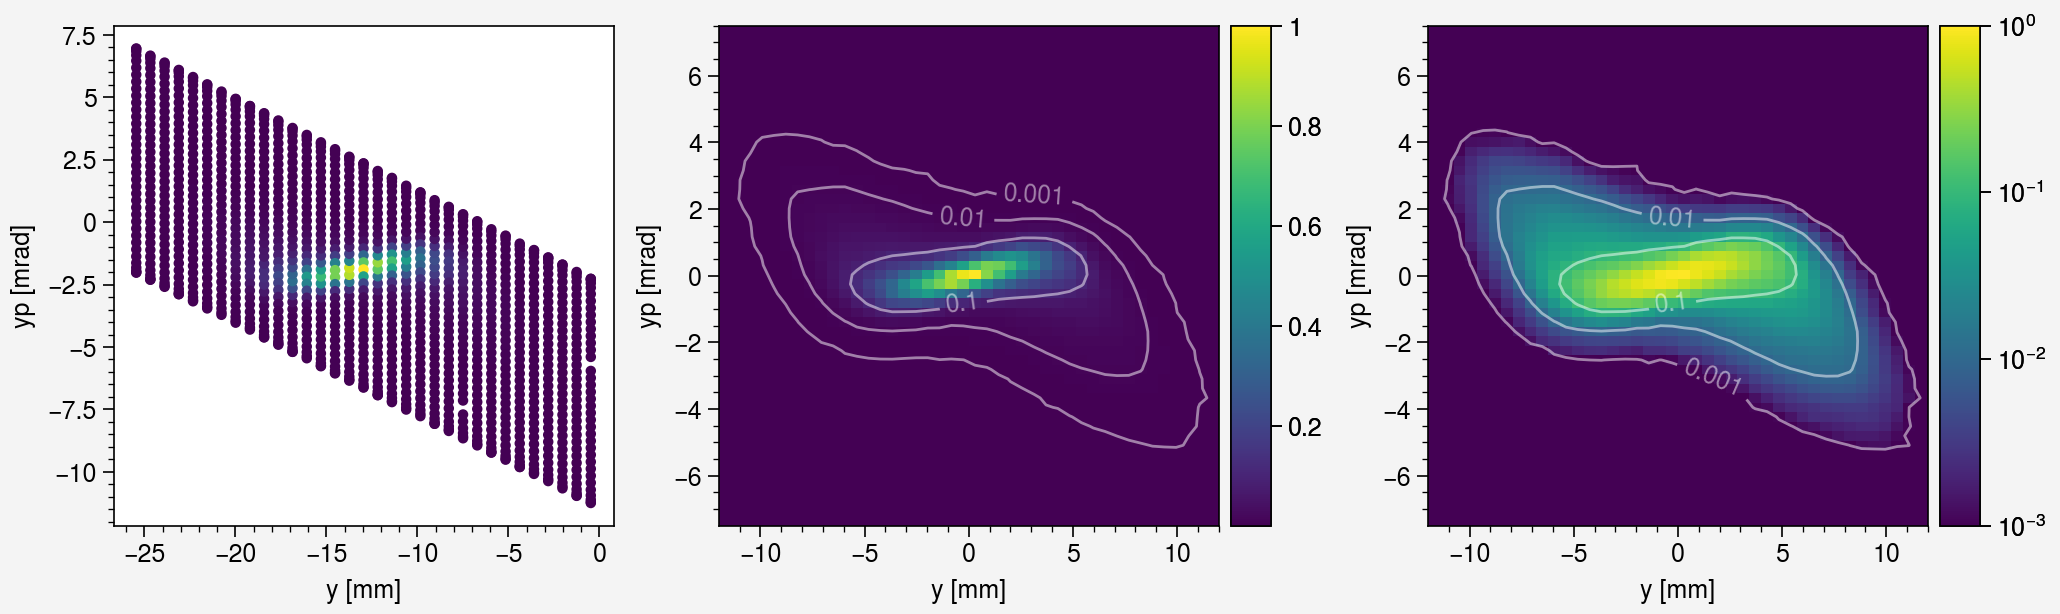

In [53]:
fig, axes = pplt.subplots(ncols=3, share=False)
axes[0].scatter(y, yp, c=signal, marker='o', s=10)
for ax, norm in zip(axes[1:], [None, 'log']):
    mplt.plot_image(f / np.max(f), x=ygrid, y=ypgrid, ax=ax,
                    vmin=0.001, vmax=1.0,
                    contour=True, contour_kws=dict(levels=[0.001, 0.01, 0.1], labels=True),
                    handle_log='floor', thresh=1e-4, thresh_type='frac', colorbar=True, norm=norm)   
axes[1:].format(ylim=(-7.5, 7.5), xlim=(-12.0, 12.0))
axes.format(xlabel='y [mm]', ylabel='yp [mrad]')

In [54]:
# df = pd.DataFrame(
#     data=np.vstack([
#         np.hstack([None, ygrid]),
#         np.hstack([ypgrid[:, None], f.T]),
#     ]),
# )
# directory = '/Users/46h/Research/code/btf-data-analysis/misc/'
# df.to_csv(
#     join(directory, f"emittance-data-y-{filename.split('-')[0]}.csv"),
#     header=False,
#     index=False,
# )

In [55]:
from tools import analysis as ba
_f = np.copy(f)
_f[_f < 0.01 * _f.max()] = 0
Sigma, mu = ba.dist_cov(_f, (ygrid, ypgrid), disp=False)
ba.beam_stats(Sigma)

{'cov': array([[ 9.54528941, -0.15445464],
        [-0.15445464,  0.41221007]]),
 'corr': array([[ 1.        , -0.07786586],
        [-0.07786586,  1.        ]]),
 'alpha': 0.07810299507712501,
 'beta': 4.826761526898252,
 'eps': 1.9775763434311913}